In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import crocoddyl
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import ValueNetwork, PolicyNetwork
import numdifftools as nd
torch.set_default_dtype(torch.double)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

$(\sqrt{x^2 + y^2} - 1)^2$ + $(\theta - \arctan2(y,x))^2$ + $(\cos\theta - y)^2$ +  $(\sin\theta - x)^2$

In [3]:
def loss_func(x):
    return (np.sqrt(x[0]**2 + x[1]**2) - 1)**2 + (x[2] - np.arctan2(x[1], x[0]))**2 + \
            (np.cos(x[2]) - x[1])**2 + (np.sin(x[2]) - x[0])**2

In [4]:
def griddedData(n_points:int = 1500,
                xy_limits:list = [-1.9,1.9],
                theta_limits:list = [-np.pi/2, np.pi/2]
                ):
    """Generate datapoints from a grid"""

    size = int(np.sqrt(n_points)) + 1

    min_x, max_x = [*xy_limits]
    xrange = np.linspace(min_x,max_x,size, endpoint=True)
    trange = np.linspace(*theta_limits, size, endpoint=True)
    points = np.array([ [x1,x2, x3] for x1 in xrange for x2 in xrange for x3 in trange])

    np.round_(points, decimals=6)
    np.random.shuffle(points)
    points = points[0:n_points, : ]
    return points

In [12]:
# ... HYPERPARAMS

FC1_DIMS              = 20
FC2_DIMS              = 20
FC3_DIMS              = 1

ACTIVATION            = nn.Tanh()
DEVICE                = 'cuda'
EPOCHS                = 1000
BATCHSIZE             = 16
LR                    = 1e-3
DECAY                 = 5e-3


In [ ]:
xtrain = griddedData(n_points=500)
xtest  = griddedData(100)

ytrain = np.array(list(map(loss_func, xtrain))).reshape(-1, 1)
ytest = np.array(list(map(loss_func, xtest))).reshape(-1, 1)

xtrain = torch.Tensor(xtrain).to(DEVICE)
ytrain = torch.Tensor(ytrain).to(DEVICE)

xtest = torch.Tensor(xtest).to(DEVICE)
ytest = torch.Tensor(ytest).to(DEVICE)

In [ ]:
net = ValueNetwork(fc1_dims=FC1_DIMS, fc2_dims=FC2_DIMS, fc3_dims=FC3_DIMS, device=DEVICE)


In [ ]:
dataset = torch.utils.data.TensorDataset(xtrain, ytrain)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = BATCHSIZE, shuffle=True)

In [ ]:
#......  CRITERIA
criterion1 = torch.nn.MSELoss(reduction='sum')
criterion2 = torch.nn.L1Loss(reduction='sum')

In [ ]:
opt = torch.optim.Adam(net.parameters(), lr = LR, betas=[0.5, 0.9], weight_decay=DECAY)

In [ ]:
for epoch in range(EPOCHS):
    for data, target in dataloader:
        net.train()
        opt.zero_grad()

        data        = data.to(DEVICE)
        target      = target.to(DEVICE)
        output      = net(data)
        loss        = torch.sqrt(criterion1(output, target)) + 0.01*criterion2(output, target)
        loss.backward()
        opt.step()
    
    # Validation
    acc = 0
    acc2 = 0
    pred = net(xtest)
    mae = torch.mean(torch.abs(pred - ytest))
    for i in range(len(xtest)):
        xtest[i].resize_(1, 3)
        pred = net(xtest[i]).item()
        if np.abs(pred - ytest[i].item()) < 0.1:
            acc += 1
        elif np.abs(pred - ytest[i].item()) < 0.5:
            acc2 += 1
    print(f"EPOCH : {epoch} || MAE : {mae} || Within 0.1: {acc}/{len(xtest)} || Within 0.5 : {acc2}/{len(xtest)}")
    
        

In [ ]:
grid = griddedData(3000, theta_limits=[0, 0])
x_val = torch.Tensor(grid).to(DEVICE)

cost = np.array(list(map(loss_func, grid))).reshape(-1, 1)


pred = net(x_val).cpu().detach().numpy().reshape(-1, 1)



In [ ]:
plt.clf()
plt.set_cmap('viridis')
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharex=True, sharey ='row')
fig.subplots_adjust(left=0.02, bottom=0.2, top=0.94)

im0 = axs[0].scatter(x = grid[:,0], y = grid[:,1], c= cost)
fig.colorbar(im0, ax=axs[0], pad=0.2)
im1 = axs[1].scatter(x = grid[:,0], y = grid[:,1], c= pred)
fig.colorbar(im1, ax=axs[1], pad=0.2)
axs[0].title.set_text("Loss Function")
axs[1].title.set_text("Prediction")
#axs[2].title.set_text("Iteration # 10")

#plt.savefig("loss1.png")


In [5]:
class TerminalModelUnicycle(crocoddyl.ActionModelAbstract):
    """
    This includes a feedforward network in crocoddyl
    
    """
    def __init__(self):
        crocoddyl.ActionModelAbstract.__init__(self, crocoddyl.StateVector(3), 2, 5)

    def calc(self, data, x, u=None):
        if u is None:
            u = self.unone
        cost = loss_func(x)
        data.cost = cost
        
    def calcDiff(self, data, x, u=None):
        if u is None:
            u = self.unone
        
        dx = nd.Gradient(loss_func)
        dxx = nd.Hessian(loss_func)
        data.Lx = dx(x)
        data.Lxx = dxx(x)
        
class TerminalNetworkUnicycle(crocoddyl.ActionModelAbstract):
    """
    This includes a feedforward network in crocoddyl
    
    """
    def __init__(self, neural_net):
        crocoddyl.ActionModelAbstract.__init__(self, crocoddyl.StateVector(3), 2, 5)
        self.net = neural_net
        device = torch.device('cpu')
        self.net.to(device)

    def calc(self, data, x, u=None):
        if u is None:
            u = self.unone
        x = torch.Tensor(x).resize_(1, 3)
        
        with torch.no_grad():
            data.cost = self.net(x).item()
        
    def calcDiff(self, data, x, u=None):
        if u is None:
            u = self.unone

        x = torch.Tensor(x).resize_(1, 3)
        
        data.Lx = self.net.jacobian(x).detach().numpy()
        data.Lxx = self.net.hessian(x).detach().numpy()


In [ ]:
ddp_cost = []
ddp_net_cost = []
grid = griddedData(3000, xy_limits=[-1.,1.],theta_limits=[0, 0])

for x0 in tqdm(grid):
    

    model = crocoddyl.ActionModelUnicycle()
    t_model = TerminalModelUnicycle()
    model.costweights = np.array([1., 1.]).T
    problem = crocoddyl.ShootingProblem(x0.T, [model]*20, t_model)
    ddp = crocoddyl.SolverDDP(problem)
    ddp.th_stop = 1e-6
    ddp.solve([], [] , 1000)
    ddp_cost.append(ddp.cost)
    
for x0 in tqdm(grid):
    model = crocoddyl.ActionModelUnicycle()
    t_model = TerminalNetworkUnicycle(net)
    model.costweights = np.array([1., 1.]).T
    problem = crocoddyl.ShootingProblem(x0.T, [model]*20, t_model)
    ddp = crocoddyl.SolverDDP(problem)
    ddp.th_stop = 1e-6

    ddp.solve([], [], 1000)
    ddp_net_cost.append(ddp.cost)


In [ ]:
error = np.array(ddp_net_cost) - np.array(ddp_cost)

In [ ]:
plt.clf()
plt.set_cmap('viridis')
fig, axs = plt.subplots(1, figsize=(5, 4), sharex=True, sharey ='row')
fig.subplots_adjust(left=0.02, bottom=0.2, top=0.94)

#im0 = axs[0].scatter(x = grid[:,0], y = grid[:,1], c= ddp_cost)
#fig.colorbar(im0, ax=axs[0], pad=0.2).set_label("Cost", fontsize = 10)
#im1 = axs[1].scatter(x = grid[:,0], y = grid[:,1], c= ddp_net_cost)
#fig.colorbar(im1, ax=axs[1], pad=0.2).set_label("Cost", fontsize = 10)

im1 = axs.scatter(x = grid[:,0], y = grid[:,1], c= error)
fig.colorbar(im2, ax=axs, pad=0.2).set_label("Error", fontsize = 10)

#axs[0].title.set_text("Crocoddyl with Loss Function")
#axs[1].title.set_text("Crocoddyl with Network.")
#axs[1].axis("off")
#axs[0].axis("off")
axs.title.set_text("Error.")

plt.savefig("Error.png")

In [ ]:
torch.save(net, 'lossNet.pth')

In [6]:
# For warmstarting

x_state = griddedData(500, xy_limits=[-1.5,1.5],theta_limits=[-np.pi/2, np.pi/2])
p_xtrain = []
p_ytrain = []
for x0 in tqdm(x_state):
    

    model = crocoddyl.ActionModelUnicycle()
    t_model = TerminalModelUnicycle()
    model.costweights = np.array([1., 1.]).T
    problem = crocoddyl.ShootingProblem(x0.T, [model]*30, t_model)
    ddp = crocoddyl.SolverDDP(problem)
    ddp.solve([], [] , 1000)
    # Dataset for policy
    for _ in ddp.xs[:-1]:
        p_xtrain.append(_)
    for _ in ddp.xs[1:]:
        p_ytrain.append(_)


100%|██████████| 500/500 [03:01<00:00,  2.76it/s]


In [7]:
p_xtrain, p_ytrain = np.array(p_xtrain), np.array(p_ytrain)

print(p_ytrain.shape)

(15000, 3)


In [92]:
pnet = PolicyNetwork(fc1_dims = 100, fc2_dims=100, fc3_dims=10, activation =nn.ReLU6(), device='cpu') 

In [93]:
p_xtest  = torch.Tensor(p_xtrain[0:100,:])
p_ytest  = torch.Tensor(p_ytrain[0:100,:])

p_xtrain = torch.Tensor(p_xtrain[100:,:])
p_ytrain = torch.Tensor(p_ytrain[100:,:])


In [94]:
p_dataset = torch.utils.data.TensorDataset(p_xtrain, p_ytrain)
p_dataloader = torch.utils.data.DataLoader(p_dataset, batch_size = 64, shuffle=True)

#......  CRITERIA
criterionp1 = torch.nn.MSELoss(reduction='mean')
criterionp2 = torch.nn.L1Loss(reduction='sum')


#.......  OPTIMIZER

popt = torch.optim.Adam(pnet.parameters(), lr = LR, betas=[0.5, 0.9], weight_decay=DECAY)

for epoch in range(EPOCHS):
    for data, target in p_dataloader:
        pnet.train()
        popt.zero_grad()


        
        output      = pnet(data)
        
        loss        = torch.sqrt(criterionp1(output, target)) 
        
        loss.backward()
        popt.step()

    # Validation
    acc = 0
    acc2 = 0
    pred = pnet(p_xtest)
    mae = torch.mean(torch.abs(pred - p_ytest))
    for i in range(len(p_xtest)):
        p_xtest[i].resize_(1, 3)
        pred = pnet(p_xtest[i]).detach().numpy()
        if np.mean(np.abs(pred - p_ytest[i].numpy())) < 0.1:
            acc += 1
        elif np.mean(np.abs(pred - p_ytest[i].numpy())) < 0.5:
            acc2 += 1
    print(f"EPOCH : {epoch} || MAE : {mae} || Within 0.1: {acc}/{len(p_xtest)} || Within 0.5 : {acc2}/{len(p_xtest)}")
    
        

EPOCH : 0 || MAE : 0.020771041554472458 || Within 0.1: 96/100 || Within 0.5 : 4/100
EPOCH : 1 || MAE : 0.025923952596351708 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 2 || MAE : 0.02183980034018211 || Within 0.1: 96/100 || Within 0.5 : 4/100
EPOCH : 3 || MAE : 0.021144674876061975 || Within 0.1: 96/100 || Within 0.5 : 4/100
EPOCH : 4 || MAE : 0.023152665199369742 || Within 0.1: 95/100 || Within 0.5 : 5/100
EPOCH : 5 || MAE : 0.01938195228064511 || Within 0.1: 95/100 || Within 0.5 : 5/100
EPOCH : 6 || MAE : 0.021780720166559905 || Within 0.1: 96/100 || Within 0.5 : 4/100
EPOCH : 7 || MAE : 0.022931455576525317 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 8 || MAE : 0.02352674770110199 || Within 0.1: 96/100 || Within 0.5 : 4/100
EPOCH : 9 || MAE : 0.02841775096280205 || Within 0.1: 95/100 || Within 0.5 : 5/100
EPOCH : 10 || MAE : 0.022831777135630348 || Within 0.1: 95/100 || Within 0.5 : 5/100
EPOCH : 11 || MAE : 0.023672940124176412 || Within 0.1: 95/100 || Within 0.5 : 

EPOCH : 97 || MAE : 0.017688328795256402 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 98 || MAE : 0.01887186393403187 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 99 || MAE : 0.01758073110921209 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 100 || MAE : 0.01876984674402926 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 101 || MAE : 0.018750494871030636 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 102 || MAE : 0.016815372934154967 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 103 || MAE : 0.020536846615220736 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 104 || MAE : 0.01905804682102115 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 105 || MAE : 0.01795078180519889 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 106 || MAE : 0.016938013214840907 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 107 || MAE : 0.018536048481797816 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 108 || MAE : 0.02112050960261456 || Within 0.1: 96/100

EPOCH : 193 || MAE : 0.02124277855268898 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 194 || MAE : 0.01994789662067624 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 195 || MAE : 0.01655787359717402 || Within 0.1: 96/100 || Within 0.5 : 4/100
EPOCH : 196 || MAE : 0.02240155930626906 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 197 || MAE : 0.02056462976207907 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 198 || MAE : 0.01790219898075411 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 199 || MAE : 0.01654416734738212 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 200 || MAE : 0.018112764064256315 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 201 || MAE : 0.01779511916814187 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 202 || MAE : 0.016429710844933783 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 203 || MAE : 0.020282548949614895 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 204 || MAE : 0.01925151842553482 || Within 0.1: 97/100

EPOCH : 289 || MAE : 0.019582041163919203 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 290 || MAE : 0.017551201985787614 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 291 || MAE : 0.018340845877436625 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 292 || MAE : 0.017345639381400886 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 293 || MAE : 0.019292116662006763 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 294 || MAE : 0.018240044180857957 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 295 || MAE : 0.019021116390388126 || Within 0.1: 96/100 || Within 0.5 : 4/100
EPOCH : 296 || MAE : 0.01818681232635526 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 297 || MAE : 0.021640973339454948 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 298 || MAE : 0.018504964454362137 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 299 || MAE : 0.018695420141707 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 300 || MAE : 0.01950320949360751 || Within 0.1: 97

EPOCH : 385 || MAE : 0.02066873504456489 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 386 || MAE : 0.017799667940045786 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 387 || MAE : 0.020077531692958773 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 388 || MAE : 0.019215789721206897 || Within 0.1: 96/100 || Within 0.5 : 4/100
EPOCH : 389 || MAE : 0.018308037680931852 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 390 || MAE : 0.01827828570519157 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 391 || MAE : 0.01955518923207727 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 392 || MAE : 0.016510060455616184 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 393 || MAE : 0.02033672824598641 || Within 0.1: 97/100 || Within 0.5 : 3/100
EPOCH : 394 || MAE : 0.018224388487236152 || Within 0.1: 96/100 || Within 0.5 : 4/100
EPOCH : 395 || MAE : 0.020331063190362514 || Within 0.1: 96/100 || Within 0.5 : 4/100
EPOCH : 396 || MAE : 0.01992900690278147 || Within 0.1: 96

KeyboardInterrupt: 

In [19]:
vnet = torch.load("lossNet.pth")

<Figure size 432x288 with 0 Axes>

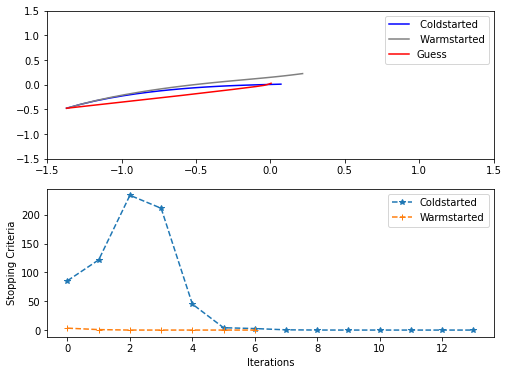

In [110]:
x  = [np.random.uniform(-1.5,1.5), np.random.uniform(-1.5,1.5), np.random.uniform(-np.pi/4, np.pi/4)]
np.round_(x, 4)

x1 = torch.Tensor(x)
guess = pnet.guess_xs(x1,30)

#... Coldstarted crocoddyl
x0 = np.array(x)
model               = crocoddyl.ActionModelUnicycle()
t_model = TerminalModelUnicycle()
model.costWeights   = np.array([1.,1.]).T
problem             = crocoddyl.ShootingProblem(x0.T, [model]*30, t_model)
ddp1                 = crocoddyl.SolverDDP(problem)
log1                 = crocoddyl.CallbackLogger()
ddp1.setCallbacks([log1])
ddp1.solve([], [], 1000)
stops1 = log1.stops[1:]
xs1 = np.array(ddp1.xs)


model2               = crocoddyl.ActionModelUnicycle()
t_model2 = TerminalNetworkUnicycle(vnet)
model.costWeights   = np.array([1.,1.]).T
problem2            = crocoddyl.ShootingProblem(x0.T, [model]*30, t_model2)
ddp2                 = crocoddyl.SolverDDP(problem2)
log2                 = crocoddyl.CallbackLogger()
ddp2.setCallbacks([log2])
ddp2.solve(guess, [], 1000)
stops2 = log2.stops[1:]
xs2 = np.array(ddp2.xs)



plt.clf()
fig, (axs1,axs2) = plt.subplots(2, figsize=(8,6))


axs1.plot(xs1[:,0], xs1[:,1], c = 'blue', label= " Coldstarted")
axs1.plot(xs2[:,0], xs2[:,1], c = 'grey', label= " Warmstarted")
axs1.plot(guess[:,0], guess[:,1], c = 'red', label = "Guess")
axs1.set_xlim([-1.5, 1.5])
axs1.set_ylim([-1.5, 1.5])
#axs1.axis("off")
axs2.plot(stops1, '--*', label = "Coldstarted")
axs2.plot(stops2, '--+', label = "Warmstarted")
axs2.set_ylabel("Stopping Criteria")
axs2.set_xlabel("Iterations")
axs1.legend()
axs2.legend()
#plt.savefig("k.png")
plt.show()

<Figure size 432x288 with 0 Axes>

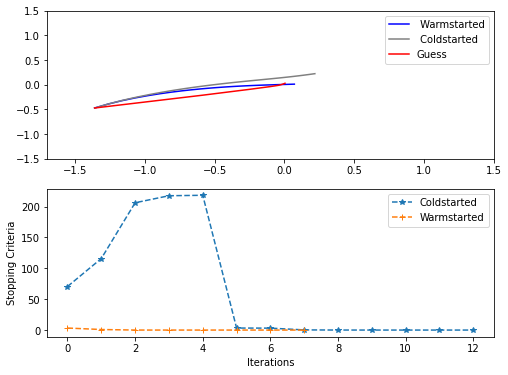

In [118]:
#x = [0.905297816719548, 0.6065832831393063, -0.6691245714742096]
x = [-1.36, -0.47, 0.69]
#np.round_(x, 4)

x1 = torch.Tensor(x)
guess = pnet.guess_xs(x1,30)

#... Coldstarted crocoddyl
x0 = np.array(x)
model               = crocoddyl.ActionModelUnicycle()
t_model = TerminalModelUnicycle()
model.costWeights   = np.array([1.,1.]).T
problem             = crocoddyl.ShootingProblem(x0.T, [model]*30, t_model)
ddp1                 = crocoddyl.SolverDDP(problem)
log1                 = crocoddyl.CallbackLogger()
ddp1.setCallbacks([log1])
ddp1.solve([], [], 1000)
stops1 = log1.stops[1:]
xs1 = np.array(ddp1.xs)


model2               = crocoddyl.ActionModelUnicycle()
t_model2 = TerminalNetworkUnicycle(vnet)
model.costWeights   = np.array([1.,1.]).T
problem2            = crocoddyl.ShootingProblem(x0.T, [model]*30, t_model2)
ddp2                 = crocoddyl.SolverDDP(problem2)
log2                 = crocoddyl.CallbackLogger()
ddp2.setCallbacks([log2])
ddp2.solve(guess, [], 1000)
stops2 = log2.stops[1:]
xs2 = np.array(ddp2.xs)



plt.clf()
fig, (axs1,axs2) = plt.subplots(2, figsize=(8,6))

axs1.plot(xs1[:,0], xs1[:,1], c = 'blue', label= " Warmstarted")
axs1.plot(xs2[:,0], xs2[:,1], c = 'grey', label= " Coldstarted")
axs1.plot(guess[:,0], guess[:,1], c = 'red', label = "Guess")
axs1.set_xlim([-1.7, 1.5])
axs1.set_ylim([-1.5, 1.5])
#axs1.set_title("x = -1.3, -0.4, 0.6")
#axs1.axis("off")
axs2.plot(stops1, '--*', label = "Coldstarted")
axs2.plot(stops2, '--+', label = "Warmstarted")
axs2.set_ylabel("Stopping Criteria")
axs2.set_xlabel("Iterations")
axs1.legend()
axs2.legend()
#plt.savefig("Wierd3.png")
plt.show()

In [112]:
weird_x

[-1.3699393919223743, -0.47511266068894487, 0.6981511935972176]